### Imports

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

from fastai.tabular import *
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [95]:
torch.manual_seed(47)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(47)

### Loading data

In [96]:
data_dir = '../input/'
!ls {data_dir}

sample_submission.csv  test.csv  train.csv


In [97]:
train_raw = pd.read_csv(f'{data_dir}train.csv')
train_raw.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [98]:
test_raw = pd.read_csv(f'{data_dir}test.csv')
test_raw.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,1c13f2701648e0b0d46d8a2a5a131a53,-5.490030,0.593976,1.532732,-0.361234,-0.155282,-1.340582,1.626819,4.280084,-0.340155,-0.653070,2.817394,1.211543,-0.819354,-0.019935,0.634466,-1.604789,0.756771,0.451960,0.309252,-4.628353,-0.270163,-0.183827,0.099529,0.719685,-1.077965,-1.704726,0.263344,1.183083,-1.967262,-0.364729,-1.553005,0.667643,-1.647120,-0.118086,1.095897,-3.725086,0.571565,5.407131,1.599479,...,-0.007170,-0.723353,-0.317083,3.892687,0.732599,-0.829353,-1.281645,5.256029,0.484761,0.315440,-1.256456,-0.065537,0.243787,-0.085292,0.293226,-0.727176,-0.026991,-0.452266,1.733475,-0.511201,-0.913642,-2.237558,-1.607618,-0.497308,0.004124,-1.854472,1.499102,-0.701304,-0.573827,0.121455,0.386831,0.817764,-1.215121,0.238812,-0.507346,1.360599,-1.743894,1.412043,-0.562730,-0.237948
1,ba88c155ba898fc8b5099893036ef205,0.571698,0.495494,1.133975,-0.315875,-2.142458,-0.478650,-1.458941,0.977352,0.159189,0.425304,1.366214,-1.097810,-0.128929,-0.563375,-0.389307,-0.167991,0.314843,0.530220,-0.512497,0.526404,1.612939,-0.800211,0.692056,2.541566,0.290910,-0.726153,1.307040,0.964062,0.235339,3.553998,-0.769491,-1.706831,0.227793,-1.027914,1.359388,-1.296281,0.216550,0.166792,-1.361746,...,8.867017,0.145251,-2.429107,-1.994984,0.692641,-0.922336,-0.442788,-0.357402,0.606270,-0.144259,-0.019312,0.132073,-1.038829,-0.361597,-0.019181,0.656320,-0.029080,-0.263428,-1.674349,0.237658,-0.539413,3.683862,0.341788,0.321800,1.919056,-0.680074,-0.851474,-0.802017,1.984299,0.606214,-1.120400,-0.953432,0.266619,-2.088512,0.252637,-1.034676,-0.804765,0.639112,1.172667,-1.666513
2,7cbab5cea99169139e7e6d8ff74ebb77,0.478202,-1.429985,0.41

In [99]:
train_raw.shape, test_raw.shape

((262144, 258), (131073, 257))

In [100]:
train_raw.isnull().sum().sum(), test_raw.isnull().sum().sum()

(0, 0)

So there are no missing values in either training or test set.

### Target distribution

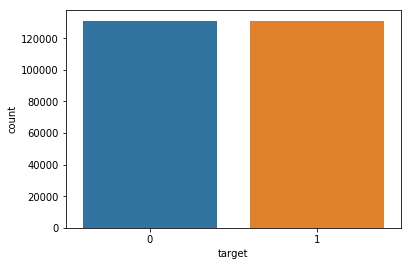

In [101]:
sns.countplot(train_raw.target)
plt.show()

In [102]:
train_raw.target.value_counts()

1    131131
0    131013
Name: target, dtype: int64

Looks like class labels are uniformly distributed in training data.

### Validation set

We will use 20,000 records from our training set as validation data.

In [103]:
valid_idx = range(len(train_raw)- 20000, len(train_raw))

### Databunch

Let's create a databunch instance with our training, validation and test data -

In [104]:
cont_names = train_raw.columns.tolist()[1:-1]
cont_names.remove('wheezy-copper-turtle-magic')

cat_names = ['wheezy-copper-turtle-magic']

procs = [FillMissing, Categorify, Normalize]

In [105]:
dep_var = 'target'

data = TabularDataBunch.from_df('.', train_raw, dep_var=dep_var, valid_idx=valid_idx, procs=procs,
                                cat_names=cat_names, cont_names=cont_names, test_df=test_raw, bs=2048)

### Learner

In [106]:
learn = tabular_learner(data, layers=[1000, 750, 500, 300], emb_szs={'wheezy-copper-turtle-magic': 200}, metrics=accuracy, ps=0.65, wd=3e-1)

Let's find optimal learning rate for our classification task -

In [107]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


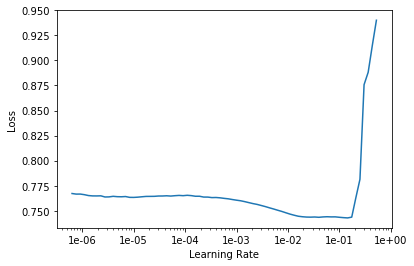

In [108]:
learn.recorder.plot()

Based on above learning rate finder graph, we can choose `1e-2` as our learning rate.

### Training

In [109]:
lr = 1e-2
learn.fit_one_cycle(26, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.704395,0.693054,0.505700,00:09
1,0.695491,0.693051,0.504450,00:09
2,0.695484,0.692788,0.515600,00:09
3,0.694782,0.691804,0.519000,00:09
4,0.692309,0.688638,0.536050,00:11
5,0.684956,0.677751,0.566900,00:10
6,0.671288,0.658843,0.611200,00:09
7,0.656848,0.645440,0.627350,00:09
8,0.645485,0.635211,0.635350,00:09
9,0.635202,0.621925,0.655450,00:09


### roc_auc_score on validation data

In [114]:
val_preds = learn.get_preds(DatasetType.Valid)
roc_auc_score(train_raw.iloc[valid_idx].target.values, val_preds[0][:,1].numpy())

0.803225300468521

### Prediction on test data

In [115]:
test_preds = learn.get_preds(DatasetType.Test)

In [116]:
sub_df = pd.read_csv(f'{data_dir}sample_submission.csv')
sub_df.target = test_preds[0][:,1].numpy()
sub_df.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.867738
1,ba88c155ba898fc8b5099893036ef205,0.764033
2,7cbab5cea99169139e7e6d8ff74ebb77,0.589069
3,ca820ad57809f62eb7b4d13f5d4371a0,0.117785
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.065953


In [117]:
sub_df.to_csv('solution.csv', index=False)